In [62]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [60]:
!pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 131.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: xformers
    Found existing installation: xformers 0.0.29.post3
    Uninstalling xformers-0.0.29.post3:
      Successfully uninstalled xformers-0.0.29.post3


In [65]:
import json
from datasets import Dataset

# Load dataset (adjust path as needed)
with open('/teamspace/studios/this_studio/NLP/arsarcasm_train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)  # For single JSON array

dataset = Dataset.from_list(data)
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")
print("Sample:", train_dataset[0])

Training samples: 11294
Evaluation samples: 1255
Sample: {'input': 'في ليلة فاقت الوصف من جمالها ي حلق في سورة غافر الشيخ عبدالله الجهني ليلة ال٢٣ من رمضان ١٤٣٢ هـ', 'is_sarcastic': False, 'sentiment': 'POS', 'dialect': 'msa', 'sarcasm_instruction': "Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.", 'sentiment_instruction': "Classify the sentiment of the given Arabic text. Return ONLY one of these labels: 'POS', 'NEG', or 'NEU' with no additional text or explanation.", 'dialect_instruction': "Identify the Arabic dialect in the given text. Return ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb' with no additional text or explanation.", 'predicted_sarcasm': '', 'predicted_sentiment': '', 'predicted_dialect': ''}


In [66]:
print(f"Total examples: {len(dataset['train']) + len(dataset['test'])}")
print("First example:", dataset['train'][0])

Total examples: 12549
First example: {'input': 'في ليلة فاقت الوصف من جمالها ي حلق في سورة غافر الشيخ عبدالله الجهني ليلة ال٢٣ من رمضان ١٤٣٢ هـ', 'is_sarcastic': False, 'sentiment': 'POS', 'dialect': 'msa', 'sarcasm_instruction': "Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.", 'sentiment_instruction': "Classify the sentiment of the given Arabic text. Return ONLY one of these labels: 'POS', 'NEG', or 'NEU' with no additional text or explanation.", 'dialect_instruction': "Identify the Arabic dialect in the given text. Return ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb' with no additional text or explanation.", 'predicted_sarcasm': '', 'predicted_sentiment': '', 'predicted_dialect': ''}


In [67]:
# 4. Create multi-task prompt template
def formatting_prompts_func(examples):
    instructions = []
    inputs = []
    outputs = []
    
    for input_text, sarc_inst, sent_inst, dial_inst, sarcasm, sentiment, dialect in zip(
        examples["input"],
        examples["sarcasm_instruction"],
        examples["sentiment_instruction"],
        examples["dialect_instruction"],
        examples["is_sarcastic"],
        examples["sentiment"],
        examples["dialect"],
    ):
        # Combined instruction for all tasks
        combined_instruction = (
            f"Perform all these tasks for the Arabic text:\n"
            f"1. {sarc_inst}\n"
            f"2. {sent_inst}\n"
            f"3. {dial_inst}\n\n"
            f"Text: {input_text}\n\n"
            "Respond with EXACTLY this format:\n"
            "Sarcasm: TRUE/FALSE\n"
            "Sentiment: POS/NEG/NEU\n"
            "Dialect: msa/egypt/gulf/levant/magreb"
        )
        
        # Combined output
        combined_output = (
            f"Sarcasm: {'TRUE' if sarcasm else 'FALSE'}\n"
            f"Sentiment: {sentiment}\n"
            f"Dialect: {dialect}"
        )
        
        instructions.append(combined_instruction)
        inputs.append(input_text)
        outputs.append(combined_output)
    
    return {"text": [f"### Instruction:\n{i}\n\n### Input:\n{x}\n\n### Response:\n{y}" 
                    for i, x, y in zip(instructions, inputs, outputs)]}

# Apply formatting
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
eval_dataset = eval_dataset.map(formatting_prompts_func, batched=True)


Map:   0%|          | 0/11294 [00:00<?, ? examples/s]

Map:   0%|          | 0/1255 [00:00<?, ? examples/s]

In [69]:
# 5. Load model
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    "Qwen/Qwen2.5-7B",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

# Add LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                  "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing=True,
    random_state=3407,
    max_seq_length=2048,
)

==((====))==  Unsloth 2025.3.14: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu118. CUDA: 8.9. CUDA Toolkit: 11.8. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [70]:
# 6. Training setup
from transformers import TrainingArguments

trainer_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    max_steps=1000,
    learning_rate=2e-5,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=10,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs",
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
)

# 7. Create trainer
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=trainer_args,
    max_seq_length=1024,
)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/11294 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/1255 [00:00<?, ? examples/s]

In [71]:
# 8. Train!
trainer.train()

# 9. Save model
model.save_pretrained("qwen_arabic_multitask")
tokenizer.save_pretrained("qwen_arabic_multitask")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11,294 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
100,0.491800,0.479141
200,0.480000,0.465717
300,0.473700,0.460322
400,0.449700,0.456891
500,0.510100,0.453897
600,0.484300,0.452014
700,0.482100,0.450305
800,0.465700,0.449390
900,0.449800,0.448772
1000,0.471000,0.448430


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


('qwen_arabic_multitask/tokenizer_config.json',
 'qwen_arabic_multitask/special_tokens_map.json',
 'qwen_arabic_multitask/vocab.json',
 'qwen_arabic_multitask/merges.txt',
 'qwen_arabic_multitask/added_tokens.json',
 'qwen_arabic_multitask/tokenizer.json')

In [72]:
# 1. First authenticate with Hugging Face
from huggingface_hub import notebook_login
notebook_login()

Token has not been saved to git credential helper.


In [96]:
# 2. Push model and tokenizer to public repository
model.push_to_hub(
    "omarwaleed523/qwen2.5-7b-arabic-multitask",
    private=False,  # Make repository public
    create_pr=False,  # Directly push to main (since new repo)
)

tokenizer.push_to_hub(
    "omarwaleed523/qwen2.5-7b-arabic-multitask",
    private=False,
    create_pr=False,
)

print("Model successfully pushed to: https://huggingface.co/omarwaleed523/qwen2.5-7b-arabic-multitask")

No files have been modified since last commit. Skipping to prevent empty commit.


Saved model to https://huggingface.co/omarwaleed523/qwen2.5-7b-arabic-multitask


No files have been modified since last commit. Skipping to prevent empty commit.


Model successfully pushed to: https://huggingface.co/omarwaleed523/qwen2.5-7b-arabic-multitask


In [125]:
!pip install seaborn

Test samples: 3000
Sample: {'input': 'اخوي حانق يالغلا وشفيك معصب عادي تراهم بشر يفطرون الصبح قلابة وتميس تيك ات ايزي مان', 'is_sarcastic': False, 'sentiment': 'NEG', 'dialect': 'msa', 'sarcasm_instruction': "Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.", 'sentiment_instruction': "Classify the sentiment of the given Arabic text. Return ONLY one of these labels: 'POS', 'NEG', or 'NEU' with no additional text or explanation.", 'dialect_instruction': "Identify the Arabic dialect in the given text. Return ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb' with no additional text or explanation.", 'predicted_sarcasm': '', 'predicted_sentiment': '', 'predicted_dialect': ''}


In [143]:
import json
from datasets import Dataset
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Load test dataset
with open('/teamspace/studios/this_studio/NLP/arsarcasm_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

test_dataset = Dataset.from_list(test_data)
print(f"Test samples: {len(test_dataset)}")
print("Sample:", test_dataset[0])

Test samples: 3000
Sample: {'input': 'اخوي حانق يالغلا وشفيك معصب عادي تراهم بشر يفطرون الصبح قلابة وتميس تيك ات ايزي مان', 'is_sarcastic': False, 'sentiment': 'NEG', 'dialect': 'msa', 'sarcasm_instruction': "Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.", 'sentiment_instruction': "Classify the sentiment of the given Arabic text. Return ONLY one of these labels: 'POS', 'NEG', or 'NEU' with no additional text or explanation.", 'dialect_instruction': "Identify the Arabic dialect in the given text. Return ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb' with no additional text or explanation.", 'predicted_sarcasm': '', 'predicted_sentiment': '', 'predicted_dialect': ''}


In [144]:

# Alpaca-style prompt template
alpaca_prompt = """### Instruction:
{instruction}

### Input:
{input}

### Response:
"""

def create_prompt(examples):
    prompts = []
    for input_text, sarc_inst, sent_inst, dial_inst in zip(
        examples["input"],
        examples["sarcasm_instruction"],
        examples["sentiment_instruction"],
        examples["dialect_instruction"],
    ):
        # Combine instructions for all tasks
        combined_instruction = (
            f"Perform all these tasks for the Arabic text:\n"
            f"1. {sarc_inst}\n"
            f"2. {sent_inst}\n"
            f"3. {dial_inst}\n\n"
            "Respond with EXACTLY this format:\n"
            "Sarcasm: TRUE/FALSE\n"
            "Sentiment: POS/NEG/NEU\n"
            "Dialect: msa/egypt/gulf/levant/magreb"
        )
        
        # Create the full prompt
        prompt = alpaca_prompt.format(instruction=combined_instruction, input=input_text, output="")
        prompts.append(prompt)
    
    return {"prompt": prompts}

# Apply the prompt formatting to the test dataset
test_dataset = test_dataset.map(create_prompt, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [138]:
# Enable faster inference
FastLanguageModel.for_inference(model)

# Simplified function to parse model output
def parse_model_output(output):
    # Initialize default values
    sarcasm, sentiment, dialect = "ERROR", "ERROR", "ERROR"
    
    # Split the output into lines
    lines = output.split("\n")
    
    # Extract values based on keywords
    for line in lines:
        if line.startswith("Sarcasm:"):
            sarcasm = line.split("Sarcasm:")[1].strip()
        elif line.startswith("Sentiment:"):
            sentiment = line.split("Sentiment:")[1].strip()
        elif line.startswith("Dialect:") or line.startswith("Dialec:"):  # Handle typo "Dialec"
            dialect = line.split(":")[1].strip()
    
    return sarcasm, sentiment, dialect

# Predictions for the full test dataset
predictions = []

for sample in tqdm(test_dataset):
    inputs = tokenizer([sample["prompt"]], return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Parse the output
    sarcasm, sentiment, dialect = parse_model_output(decoded_output)
    predictions.append((sarcasm, sentiment, dialect))

# Extract true labels
true_labels = [
    ("TRUE" if sample["is_sarcastic"] else "FALSE", sample["sentiment"], sample["dialect"])
    for sample in test_dataset
]

print("Predictions (first 10):", predictions[:10])
print("True Labels (first 10):", true_labels[:10])

  1%|          | 25/3000 [01:08<2:14:04,  2.70s/it]

In [139]:

# Filter out invalid predictions
valid_indices = [
    i for i, (pred_sarcasm, pred_sentiment, pred_dialect) in enumerate(predictions)
    if pred_sarcasm != "ERROR" and pred_sentiment != "ERROR" and pred_dialect != "ERROR"
]

filtered_predictions = [predictions[i] for i in valid_indices]
filtered_true_labels = [true_labels[i] for i in valid_indices]

if not filtered_predictions:
    raise ValueError("No valid predictions found. Check the parsing logic.")

# Separate filtered predictions and true labels for each task
true_sarcasm, pred_sarcasm = zip(*[(true[0], pred[0]) for true, pred in zip(filtered_true_labels, filtered_predictions)])
true_sentiment, pred_sentiment = zip(*[(true[1], pred[1]) for true, pred in zip(filtered_true_labels, filtered_predictions)])
true_dialect, pred_dialect = zip(*[(true[2], pred[2]) for true, pred in zip(filtered_true_labels, filtered_predictions)])

# Specify all possible labels for each task
sarcasm_labels = ["FALSE", "TRUE"]
sentiment_labels = ["POS", "NEG", "NEU"]
dialect_labels = ["msa", "egypt", "gulf", "levant", "magreb"]

In [132]:
# Function to plot confusion matrix using Seaborn
def plot_confusion_matrix(true_labels, pred_labels, labels, title):
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Sarcasm Confusion Matrix:


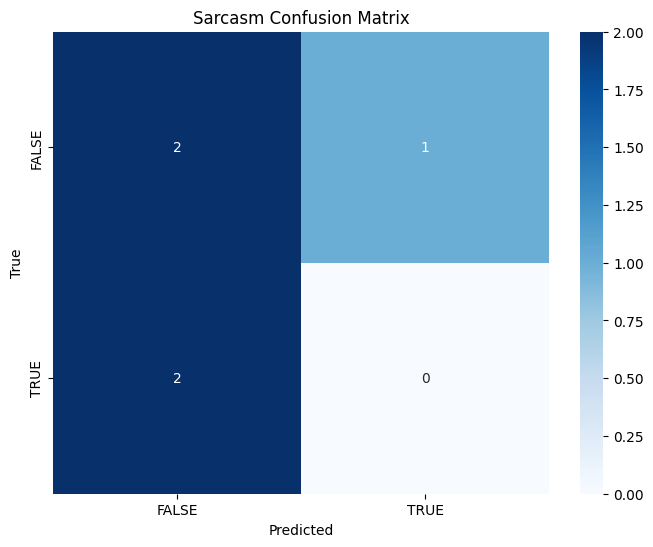

Sarcasm Classification Report:
              precision    recall  f1-score   support

       FALSE       0.50      0.67      0.57         3
        TRUE       0.00      0.00      0.00         2

    accuracy                           0.40         5
   macro avg       0.25      0.33      0.29         5
weighted avg       0.30      0.40      0.34         5



In [ ]:
# Sarcasm Evaluation
print("Sarcasm Confusion Matrix:")
plot_confusion_matrix(true_sarcasm, pred_sarcasm, sarcasm_labels, "Sarcasm Confusion Matrix")

print("Sarcasm Classification Report:")
print(classification_report(
    true_sarcasm, pred_sarcasm, 
    labels=sarcasm_labels, 
    target_names=sarcasm_labels, 
    zero_division=0  # Handle cases where a class has no predictions
))

Sentiment Confusion Matrix:


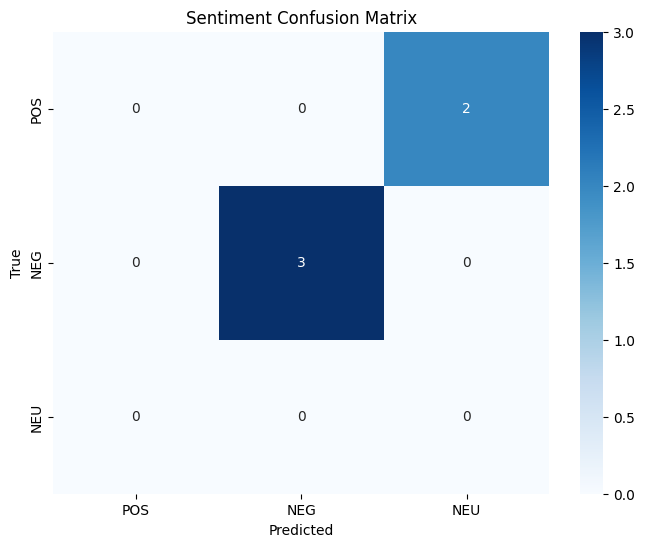

Sentiment Classification Report:
              precision    recall  f1-score   support

         POS       0.00      0.00      0.00         2
         NEG       1.00      1.00      1.00         3
         NEU       0.00      0.00      0.00         0

    accuracy                           0.60         5
   macro avg       0.33      0.33      0.33         5
weighted avg       0.60      0.60      0.60         5



In [ ]:
# Sentiment Evaluation
print("Sentiment Confusion Matrix:")
plot_confusion_matrix(true_sentiment, pred_sentiment, sentiment_labels, "Sentiment Confusion Matrix")

print("Sentiment Classification Report:")
print(classification_report(
    true_sentiment, pred_sentiment, 
    labels=sentiment_labels, 
    target_names=sentiment_labels, 
    zero_division=0  # Handle cases where a class has no predictions
))

Dialect Confusion Matrix:


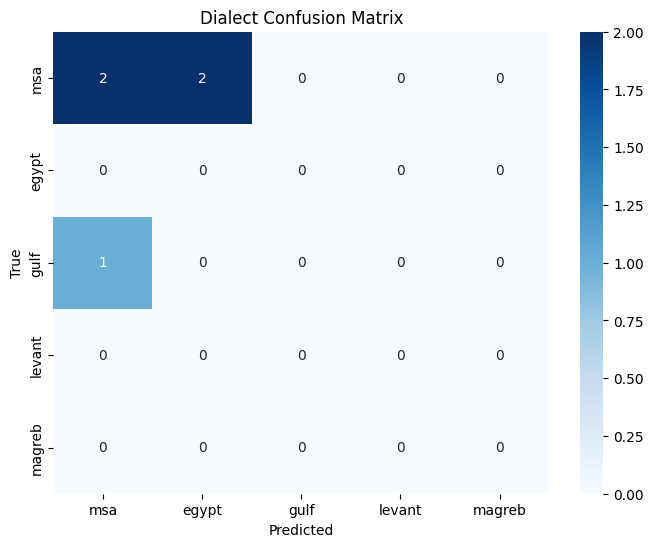

Dialect Classification Report:
              precision    recall  f1-score   support

         msa       0.67      0.50      0.57         4
       egypt       0.00      0.00      0.00         0
        gulf       0.00      0.00      0.00         1
      levant       0.00      0.00      0.00         0
      magreb       0.00      0.00      0.00         0

   micro avg       0.40      0.40      0.40         5
   macro avg       0.13      0.10      0.11         5
weighted avg       0.53      0.40      0.46         5



In [ ]:
# Dialect Evaluation
print("Dialect Confusion Matrix:")
plot_confusion_matrix(true_dialect, pred_dialect, dialect_labels, "Dialect Confusion Matrix")

print("Dialect Classification Report:")
print(classification_report(
    true_dialect, pred_dialect, 
    labels=dialect_labels, 
    target_names=dialect_labels, 
    zero_division=0  # Handle cases where a class has no predictions
))